(MCP-lab)=
# MCP Neuron 

In [1]:
import numpy as np              # numeric 
import matplotlib.pyplot as plt # plotting

import os.path 

isdir = os.path.isdir('lib_nn') # check whether 'lib_nn' exists

if not isdir:
   !git clone https://github.com/bronwojtek/lib_nn.git # cloning the library from github

import sys                     
sys.path.append('./lib_nn') 

from neural import *            # importing my library package

Invoking __init__.py for neural


## Definition

We need a basic building block of ANNs: the artificial neuron. The first mathematical model dates back to Warren McCulloch and Walter Pitts (MCP){cite}`McCulloch1943`, who proposed it in 1942, hence at the very beginning of the electronic computer age during World War II. The MCP neuron depicted in {numref}`MCP1-fig` is a basic ingredient of all ANNs discussed in this course. It is built on very simple general rules, inspired neatly by the biological neuron:

- The signal enters the nucleus via dendrites from other neurons.
- The synaptic connection for each dendrite may have a different (and adjustable) strength (weight).
- In the nucleus, the signal from all the dendrites is combined (summed up) into $s$.
- If the combined signal is stronger than a given threshold, then the neuron fires along the axon, in the opposite case it remains still. 
- In the simplest realization, the strength of the fired signal has two possible levels: on or off, i.e. 1 or 0. No intermediate values are needed.
- Axon terminal connects to dendrites of other neurons. 

:::{figure-md} MCP1-fig
<img src="images/mcp-1a.png" width="320px">

MCP neuron: $x_i$ is the input, $w_i$ are the weights, $s$ is the signal, $b$ is the bias, and $f(s;b)$ represents an activation function, yielding the output $y=f(s;b)$. The blue oval encircles the whole neuron, as used e.g. in {numref}`ffnn-fig`.
:::

Translating this into a mathematical prescription, one assigns to the input cells the numbers $x_1, x_2 \dots, x_n$ (input data point). The strength of the synaptic connections is controlled with the **weights** $w_i$. Then the combined signal is defined as the weighted sum 

$$s=\sum_{i=1}^n x_i w_i.$$

The signal becomes an argument of the **activation function**, which, in the simplest case, takes the form of the step function

$$
f(s;b) = \left \{ \begin{array}{l} 1 {\rm ~for~} s \ge b \\ 0 {\rm ~for~} s < b \end{array} \right .
$$

When the combined signal $s$ is larger than the bias (threshold) $b$, the nucleus fires. i.e. the signal passed along the axon is 1. in the opposite case, the generated signal value is 0 (no firing). This is precisely what we need to mimic the biological prototype.

There is a convenient notational convention that is frequently used. Instead of splitting the bias from the input data, we may treat all uniformly. The condition for firing may be trivially transformed as

$$
s \ge b  \to s-b \ge 0 \to \sum_{i=1}^n x_i w_i - b \ge 0 \to \sum_{i=1}^n x_i w_i +x_0 w_0 \ge 0 
\to \sum_{i=0}^n x_i w_i \ge 0,
$$

where $x_0=1$ and $w_0=-b$. In other words, we may treat the bias as a weight on the edge connected to an additional cell with the input always fixed to 1. This notation is shown in {numref}`MCP2-fig`. Now, the activation function is simply 

```{math}
:label: eq-f

f(s) = \left \{ \begin{array}{l} 1 {\rm ~for~} s \ge 0 \\ 0 {\rm ~for~} s < 0 \end{array} \right .,
```

with the summation index in $s$ starting from $0$:

```{math}
:label: eq-f0
s=\sum_{i=0}^n x_i w_i = x_0 w_0+x_1 w_1 + \dots + x_n w_n.
```

:::{figure-md} MCP2-fig
<img src="images/mcp-2a.png" width="320px">

Alternative, more uniform representation of the MCP neuron, with $x_0=1$ and $w_0=-b$.
:::

```{admonition} Hyperparameters
The weights $w_0=-b,w_1,\dots,w_n$ are generally referred to as **hyperparameters**. They determine the functionality of the MCP neuron and may be changed during the learning (training) process (see the following). However, they are kept fixed when using the trained neuron on a particular input data sample.
```

```{important}
An essential property of neurons in ANNs is **nonlinearity** of the activation function. Without this feature, the MCP neuron would simply represent a scalar product, and the feed-forward networks would just involve trivial matrix multiplications.
```

(mcp_P-lab)=
## MCP neuron in Python

We now implement the mathematical model of the neuron of Sec. {ref}`MCP-lab` in Python. First, we obviously need arrays (vectors), which are represented as

In [2]:
x = [1,3,7]
w = [1,1,2.5]

and (**important**) are indexed starting from 0, e.g.

In [3]:
x[0]

1

(note that typing a variable at the end of a notebook cell prints out its content). The numpy library functions carry the prefix **np**, which is the alias given at import. Note that these functions act *distributively* over arrays, e.g.

In [4]:
np.sin(x)

array([0.84147098, 0.14112001, 0.6569866 ])

which is a very convenient feature when programming. We also have the scalar product $x \cdot w = \sum_i x_i w_i$ handy, which we use to build the combined signal $s$ entering the MCP neuron:

In [5]:
np.dot(x,w)

21.5

Next, we need to construct the neuron activation function, which presently is just the step function {eq}`eq-f`:

In [6]:
def step(s):       # step function
     if s > 0:     # condition satisfied
        return 1
     else:         # otherwise
        return 0

where in the top comments we have indicated that the function is also defined in the **neural** library package, cf. [Appendix](app-lab). For the visualizers, the plot of the step function is following:

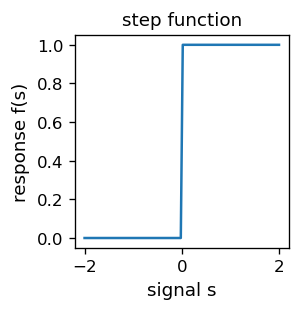

In [7]:
plt.figure(figsize=(2.3,2.3),dpi=120) # set the size and resolution of the figure

s = np.linspace(-2, 2, 100)   # array of 100+1 equally spaced points in [-2, 2]
fs = [step(z) for z in s]     # corresponding array of function values

plt.xlabel('signal s',fontsize=11)      # axes labels
plt.ylabel('response f(s)',fontsize=11)
plt.title('step function',fontsize=11)  # plot title

plt.plot(s, fs)
plt.show()

Since $x_0=1$ always, we do not want to explicitly carry this over in the arguments of functions that will follow. We will be frequently inserting $x_0=1$ into the input, for instance: 

In [8]:
x=[5,7]
np.insert(x,0,1) # insert 1 in x at position 0

array([1, 5, 7])

Now we are ready to construct the [MCP neuron](MCP1-fig):

In [9]:
def neuron(x,w,f=step): # (in the neural library)
    """                 
    MCP neuron

    x: array of inputs  [x1, x2,...,xn]
    w: array of weights [w0, w1, w2,...,wn]
    f: activation function, with step as default
    
    return: signal=weighted sum w0 + x1 w1 + x2 w2 +...+ xn wn = x.w
    """ 
    return f(np.dot(np.insert(x,0,1),w)) # insert x0=1 into x, output f(x.w)

We diligently put the comments in triple quotes to be able to get a useful help when needed:

In [10]:
help(neuron)

Help on function neuron in module __main__:

neuron(x, w, f=<function step at 0x7fe444256550>)
    MCP neuron
    
    x: array of inputs  [x1, x2,...,xn]
    w: array of weights [w0, w1, w2,...,wn]
    f: activation function, with step as default
    
    return: signal=weighted sum w0 + x1 w1 + x2 w2 +...+ xn wn = x.w



Note that function **f** is an argument of **neuron**. It is by default set to **step**, thus does not have to be present in the argument list. A sample usage with $x_1=3$, $w_0=-b=-2$, $w_1=1$ is 

In [11]:
neuron([3],[-2,1])

1

As we can see, the neuron fired in this case, because $s=1*(-2)+3*1>0$. 

Next, we show how the neuron operates on an input sample $x_1$ taken in the range $[-2,2]$. We also change the bias parameter, to illustrate its role. It is clear that the bias works as the threshold: if the signal $x_1 w_1$ is above $b=-x_0$, then the neuron fires.

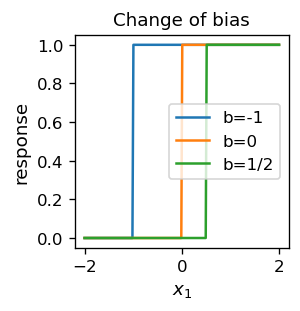

In [12]:
plt.figure(figsize=(2.3,2.3),dpi=120) 

s = np.linspace(-2, 2, 200)
fs1 = [neuron([x1],[1,1]) for x1 in s]      # more function on one plot
fs0 = [neuron([x1],[0,1]) for x1 in s]
fsm12 = [neuron([x1],[-1/2,1]) for x1 in s]

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('response',fontsize=11)

plt.title("Change of bias",fontsize=11)

plt.plot(s, fs1, label='b=-1')
plt.plot(s, fs0, label='b=0')
plt.plot(s, fsm12, label='b=1/2')
plt.legend()     # legend
plt.show()

When the sign of the weight $w_1$ is negative, we get a **reverse** behavior, where the neuron fires when $x_1 |w_1| < w_0$: 

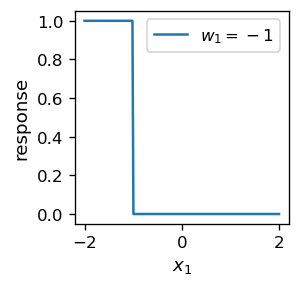

In [13]:
plt.figure(figsize=(2.3,2.3),dpi=120) 

s = np.linspace(-2, 2, 200)
gsm = [neuron([x1],[-1,-1]) for x1 in s]

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('response',fontsize=11)

plt.plot(s, gsm,label='$w_1=-1$')
plt.legend()
plt.show()

```{note} 
From now on, for the brevity of the presentation, we hide some cells of the code with repeated structure. The reader may find the complete code in the corresponding Jupyter notebooks.
```

Admittedly, in the last example, one departs from the biological pattern, as negative weights are not possible to realize in a biological neuron. However, this freedom enriches the mathematical model, which clearly can be built without biological constraints.

(bool-sec)=
## Boolean functions

Having constructed the MCP neuron in Python, the question is: *What is the simplest (but still non-trivial) application we can use it for?* We show here that one can easily construct [boolean functions](https://en.wikipedia.org/wiki/Boolean_function), or logical networks, with the help of networks of MCP neurons. Boolean functions, by definition, have arguments and values in the set $\{ 0,1 \}$, or {True, False}.

To warm up, let us start with some guesswork, where we take the neuron with the weights $w=[w_0,w_1,w_2]=[-1,0.6,0.6]$ (why not). We shall here denote $x_1=p$, $x_2=q$, in accordance with the traditional notation for logical variables, where $p,q \in \{0,1\}$. 

In [14]:
print("p q n(p,q)") # print the header
print()             # print space

for p in [0,1]:       # loop over p
    for q in [0,1]:   # loop over q
        print(p,q,"",neuron([p,q],[-1,.6,.6])) # print all cases

p q n(p,q)

0 0  0
0 1  0
1 0  0
1 1  1


We immediately recognize in the above output the logical table for the conjunction, $n(p,q)=p \land q$, or the logical **AND** operation. It is clear how the neuron works. The condition for the firing $n(p,q)=1$ is $-1+p*0.6+q*0.6 \ge 0$, and it is satisfied if and only if $p=q=1$, which is the definition of the logical conjunction. Of course, we could have used here 0.7 instead of 0.6, or in general $w_1$ and $w_2$ such that $w_1<1, w_2<1, w_1+w_2 \ge 1$. In the electronics terminology, we can call the present neuron the **AND gate**.

We can thus define the short-hand 

In [15]:
def neurAND(p,q): return neuron([p,q],[-1,.6,.6])

Quite similarly, we may define other boolean functions (or logical gates) of two logical variables. In particular, the NAND gate (the negation of conjunction) and the OR gate (alternative) are realized with the following MCP neurons:

In [16]:
def neurNAND(p,q): return neuron([p,q],[1,-0.6,-0.6])
def neurOR(p,q):   return neuron([p,q],[-1,1.2,1.2])

They correspond to the logical tables 

In [17]:
print("p q  NAND OR") # print the header
print()

for p in [0,1]: 
    for q in [0,1]: 
        print(p,q," ",neurNAND(p,q)," ",neurOR(p,q))

p q  NAND OR

0 0   1   0
0 1   1   1
1 0   1   1
1 1   0   1


### Problem with XOR

The XOR gate, or the **exclusive alternative**, is defined with the following logical table:

$$
\begin{array}{ccc}
p & q & p \oplus q \\
0 & 0 & 0 \\
0 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 0
\end{array}
$$

This is one of the possible boolean functions of two arguments (in total, we have 16 different functions of this kind, why?). We could now try very hard to adjust the weights in our neuron to make it behave as the XOR gate, but we are doomed to fail. Here is the reason:

From the first row of the above table, it follows that for the input 0, 0 (first row) the neuron should not fire. Hence

$w_0  + 0* w_1 + 0*w_2  < 0$, or $-w_0>0$. 

For the cases of rows 2 and 3 the neuron must fire, therefore

$w_0+w_2 \ge 0$ and $w_0+w_1 \ge 0$.

Adding side-by-side the three obtained inequalities we get $w_0+w_1+w_2 > 0$. However, the fourth row yields
$w_0+w_1+w_2<0$ (no firing), so we encounter a contradiction. Therefore no choice of $w_0, w_1, w_2$ exists to do the job! 

```{important}
A single MCP neuron cannot represent the **XOR** gate.
```

### XOR from composition of AND, NAND and OR

One can solve the XOR problem by composing three MCP neurons, for instance 

In [18]:
def neurXOR(p,q): return neurAND(neurNAND(p,q),neurOR(p,q))

In [19]:
print("p q XOR") 
print()

for p in [0,1]: 
    for q in [0,1]: 
        print(p,q,"",neurXOR(p,q))

p q XOR

0 0  0
0 1  1
1 0  1
1 1  0


The above construction corresponds to the simple network of {numref}`xor-fig`.


:::{figure-md} xor-fig
<img src="images/xor.png" width="260px">

The XOR gate composed of the NAND, OR, and AND MCP neurons.
:::

Note that we are dealing here, for the first time, with a network having an intermediate layer, consisting of the NAND and OR neurons. This layer is indispensable to construct the XOR gate.

### XOR composed from NAND

Within the theory of logical networks, one proves that any network (or any boolean function) can be composed of only NAND gates, or only the NOR gates. One says that the NAND (or NOR) gates are **complete**. In particular, the XOR gate can be constructed as 

[ p NAND ( p NAND q ) ] NAND [ q NAND ( p NAND q ) ],

which we can write in Python as

In [20]:
def nXOR(i,j): return neurNAND(neurNAND(i,neurNAND(i,j)),neurNAND(j,neurNAND(i,j)))

In [21]:
print("p q XOR") 
print()

for i in [0,1]: 
    for j in [0,1]: 
        print(i,j,"",nXOR(i,j)) 

p q XOR

0 0  0
0 1  1
1 0  1
1 1  0


```{note}
One proves that logical networks are complete in the [Church-Turing](https://en.wikipedia.org/wiki/Church–Turing_thesis) sense, i.e., (when sufficiently large) may carry over any possible calculation. This feature directly carries over to ANNs. Historically, that was the basic finding of the seminal MCP paper {cite}`McCulloch1943`.
```

```{admonition} Conclusion
:class: Important

ANNs (sufficiently large) can perform any calculation!
```

## Exercises

```{admonition} $~$
:class: warning


Construct (all in Python)

- a gate realizing conjunction of multiple boolean variables;
- gates NOT, NOR;
- gates OR, AND, NOT by [composing NAND gates](https://en.wikipedia.org/wiki/NAND_logic); 
- the [half adder and full adder](https://en.wikipedia.org/wiki/Adder_(electronics)),

as networks of MCP neurons.
```